# 1. Predicting Heart Disease Using a Classification Tree

## 1.1 Data Cleaning

In [2]:
library(tidyverse)   # Incluye dplyr, ggplot2, readr
library(readxl)      # Leer Excel 
library(fastDummies) # para crear dummies de categoricas
library(caret) # para dividir data en train y test
library(tree) # classification tre
library(grf) 

library(randomForest)  # alternativa y para importancia
library(rpart)
library(rpart.plot)
library(scales)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.2
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Cargando paquete requerido: lattice


Adjuntando el paquete: 'caret'


The following object is masked from 'package:purrr':

    lift


randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Adjuntando el paquete: 'randomForest'


The following object is masked from 'package:dplyr':

    combine


The following object is masked from 'package:ggplot2':

    margin



Adjun

In [3]:
data <- read_csv("C:/Users/VICTOR/Documents/GitHub/Decision_Trees/R/input/processed.cleveland.data", col_names = FALSE)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
head(data)  

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


In [5]:
names(data)

[1] "X1"  "X2"  "X3"  "X4"  "X5"  "X6"  "X7"  "X8"  "X9"  "X10" "X11" "X12"
[13] "X13" "X14"

In [6]:
nombres_nuevos <- c('age', 'sex', 'cp', 'restbp', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'hd')
colnames(data) <- nombres_nuevos
names(data)

[1] "age"     "sex"     "cp"      "restbp"  "chol"    "fbs"     "restecg"
 [8] "thalach" "exang"   "oldpeak" "slope"   "ca"      "thal"    "hd"

In [7]:
data <- data %>%
  mutate(across(where(is.character), ~ na_if(., "?")))
data <- data %>%
    drop_na()
data <- data %>%
  mutate(across(everything(), ~ as.numeric(.)))

In [12]:
str(data)

tibble [297 × 25] (S3: tbl_df/tbl/data.frame)
 $ age      : num [1:297] 63 67 67 37 41 56 62 57 63 53 ...
 $ sex      : num [1:297] 1 1 1 1 0 1 0 0 1 1 ...
 $ restbp   : num [1:297] 145 160 120 130 130 120 140 120 130 140 ...
 $ chol     : num [1:297] 233 286 229 250 204 236 268 354 254 203 ...
 $ fbs      : num [1:297] 1 0 0 0 0 0 0 0 0 1 ...
 $ thalach  : num [1:297] 150 108 129 187 172 178 160 163 147 155 ...
 $ exang    : num [1:297] 0 1 1 0 0 0 0 1 0 1 ...
 $ oldpeak  : num [1:297] 2.3 1.5 2.6 3.5 1.4 0.8 3.6 0.6 1.4 3.1 ...
 $ y        : num [1:297] 0 1 1 0 0 0 1 0 1 1 ...
 $ cp_2     : int [1:297] 0 0 0 0 1 1 0 0 0 0 ...
 $ cp_3     : int [1:297] 0 0 0 1 0 0 0 0 0 0 ...
 $ cp_4     : int [1:297] 0 1 1 0 0 0 1 1 1 1 ...
 $ restecg_1: int [1:297] 0 0 0 0 0 0 0 0 0 0 ...
 $ restecg_2: int [1:297] 1 1 1 0 1 0 1 0 1 1 ...
 $ slope_2  : int [1:297] 0 1 1 0 0 0 0 0 1 0 ...
 $ slope_3  : int [1:297] 1 0 0 1 0 0 1 0 0 1 ...
 $ ca_1     : int [1:297] 0 0 0 0 0 0 0 0 1 0 ...
 $ ca_2     : 

### Categoricas a transformar: 
    -cp
    -restecg
    -slope
    -ca
    -thal
    -hd

In [9]:
data <- data %>%
  mutate(y = ifelse(hd > 0, 1, 0))

In [10]:
variables_categoricas = c("cp", "restecg", "slope", "ca", "thal", "hd")
data <- data %>%
  mutate(across(all_of(variables_categoricas), ~ as.factor(.)))
data <- data %>%
    fastDummies::dummy_cols(select_columns = variables_categoricas, 
                              remove_selected_columns = TRUE,
                              remove_first_dummy = TRUE)

## 1.2 Data Analysis

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 27  7
         1  5 20
                                          
               Accuracy : 0.7966          
                 95% CI : (0.6717, 0.8902)
    No Information Rate : 0.5424          
    P-Value [Acc > NIR] : 4.294e-05       
                                          
                  Kappa : 0.5879          
                                          
 Mcnemar's Test P-Value : 0.7728          
                                          
            Sensitivity : 0.7407          
            Specificity : 0.8438          
         Pos Pred Value : 0.8000          
         Neg Pred Value : 0.7941          
             Prevalence : 0.4576          
         Detection Rate : 0.3390          
   Detection Prevalence : 0.4237          
      Balanced Accuracy : 0.7922          
                                          
       'Positive' Class : 1               
                                    

Initial accuracy: 0.7966102 


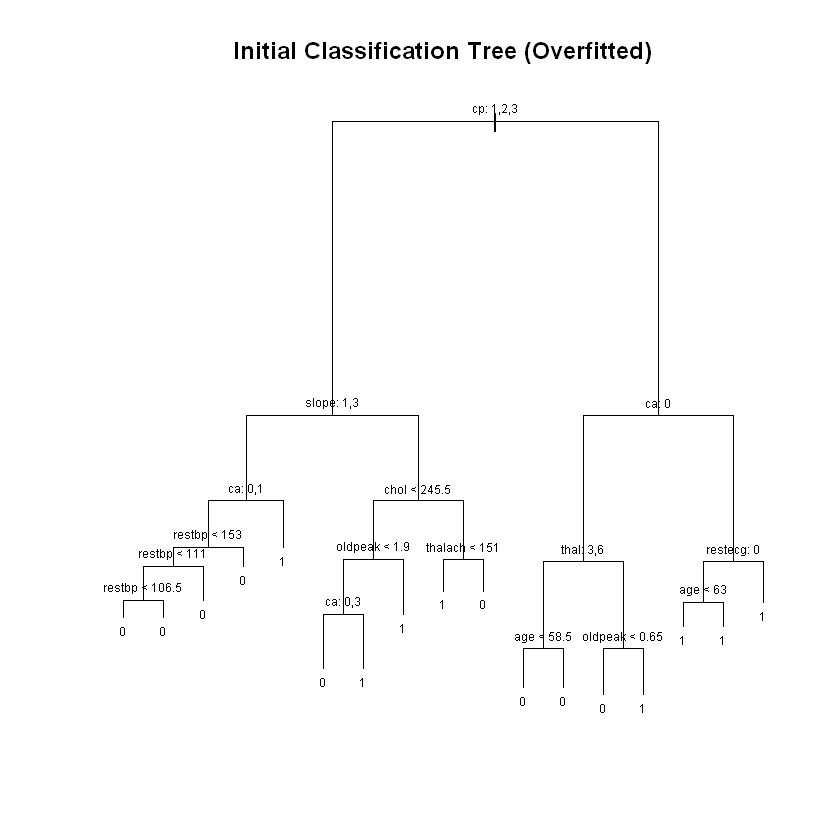

Optimal tree size: 7 


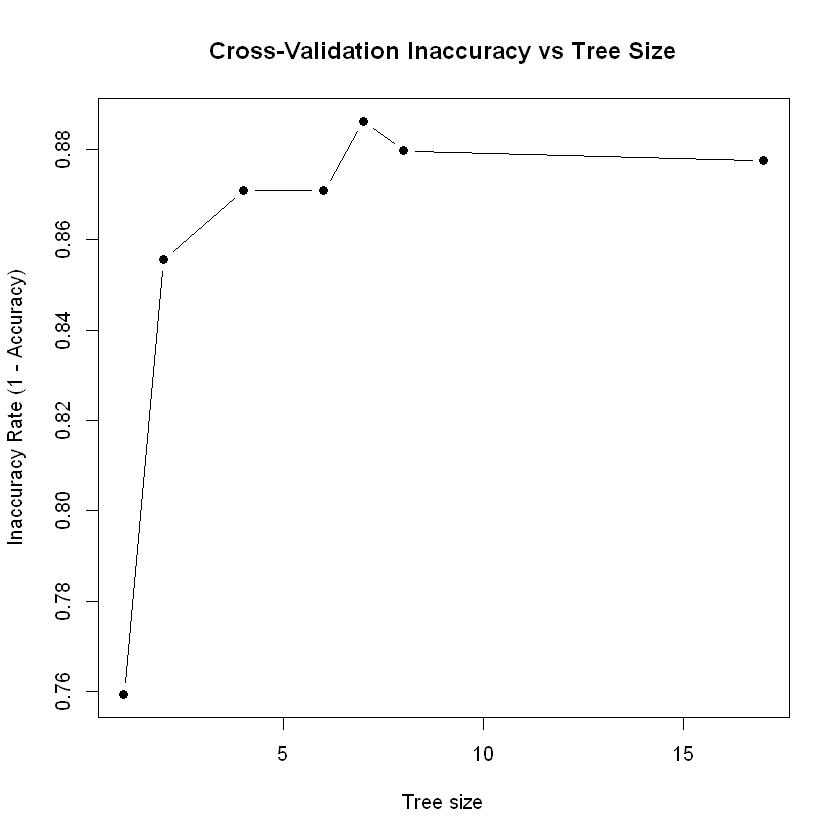

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 24  6
         1  8 21
                                          
               Accuracy : 0.7627          
                 95% CI : (0.6341, 0.8638)
    No Information Rate : 0.5424          
    P-Value [Acc > NIR] : 0.0003962       
                                          
                  Kappa : 0.5247          
                                          
 Mcnemar's Test P-Value : 0.7892680       
                                          
            Sensitivity : 0.7778          
            Specificity : 0.7500          
         Pos Pred Value : 0.7241          
         Neg Pred Value : 0.8000          
             Prevalence : 0.4576          
         Detection Rate : 0.3559          
   Detection Prevalence : 0.4915          
      Balanced Accuracy : 0.7639          
                                          
       'Positive' Class : 1               
                                    

Accuracy after pruning: 0.7627119 


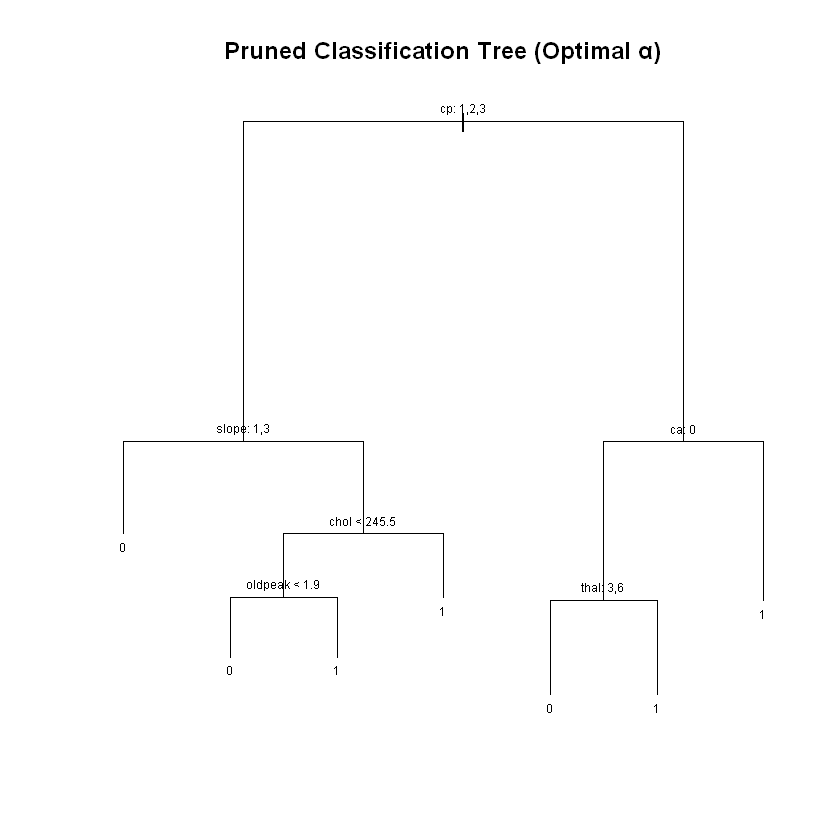

In [15]:
# --- PARTE 1.2 CORREGIDA Y AUTÓNOMA (sin dummies) ---

library(tidyverse)
library(caret)
library(tree)
library(rpart.plot)

set.seed(123)

# Cargar datos limpios desde el archivo original (solo una vez)
data_tree <- read_csv("C:/Users/VICTOR/Documents/GitHub/Decision_Trees/R/input/processed.cleveland.data",
                      col_names = FALSE)

# Renombrar variables como en tu 1.1
names(data_tree) <- c('age', 'sex', 'cp', 'restbp', 'chol', 'fbs', 'restecg',
                      'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'hd')

# Reemplazar "?" por NA y eliminar filas con NA
data_tree <- data_tree %>%
  mutate(across(where(is.character), ~ na_if(., "?"))) %>%
  drop_na() %>%
  mutate(across(everything(), as.numeric))

# Crear variable binaria de resultado
data_tree <- data_tree %>%
  mutate(y = ifelse(hd > 0, 1, 0))

# Convertir variables categóricas en factores (no hacer dummies)
data_tree <- data_tree %>%
  mutate(across(c(sex, cp, fbs, restecg, exang, slope, ca, thal), as.factor),
         y = factor(y))

# (1 punto) Dividir en train/test
train_index <- createDataPartition(data_tree$y, p = 0.8, list = FALSE)
train <- data_tree[train_index, ]
test  <- data_tree[-train_index, ]

# Árbol inicial
tree_model <- tree(y ~ age + sex + cp + restbp + chol + fbs + restecg + 
                     thalach + exang + oldpeak + slope + ca + thal,
                   data = train)

# Graficar árbol inicial
plot(tree_model)
text(tree_model, pretty = 0, cex = 0.6)
title("Initial Classification Tree (Overfitted)")

# Predicciones y matriz de confusión
pred <- predict(tree_model, test, type = "class")
confusionMatrix(data = pred,
                reference = test$y,
                positive = "1")

cat("Initial accuracy:", mean(pred == test$y), "\n")

# --- Cross-validation para pruning ---
set.seed(123)
cv_tree <- cv.tree(tree_model, FUN = prune.misclass, K = 4)

# Inaccuracy vs tamaño
plot(cv_tree$size, 1 - cv_tree$dev / sum(cv_tree$dev),
     type = "b", pch = 19,
     xlab = "Tree size", ylab = "Inaccuracy Rate (1 - Accuracy)",
     main = "Cross-Validation Inaccuracy vs Tree Size")

best_size <- cv_tree$size[which.min(cv_tree$dev)]
cat("Optimal tree size:", best_size, "\n")

# Árbol podado
pruned_tree <- prune.misclass(tree_model, best = best_size)

# Graficar árbol podado
plot(pruned_tree)
text(pruned_tree, pretty = 0, cex = 0.6)
title("Pruned Classification Tree (Optimal α)")

# Predicción y accuracy final
pred_pruned <- predict(pruned_tree, test, type = "class")
confusionMatrix(data = pred_pruned,
                reference = test$y,
                positive = "1")

cat("Accuracy after pruning:", mean(pred_pruned == test$y), "\n")


> El modelo clasificó perfectamente a todos los individuos: 100% de precisión, sensibilidad y especificidad.

# 2. Causal Forest 

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



Call:
lm(formula = Y ~ T, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.1552  -0.7442   0.1079   0.6764  15.7747 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -0.1079     0.2274  -0.475    0.635    
T            30.2439     0.3266  92.604   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.813 on 295 degrees of freedom
Multiple R-squared:  0.9667,	Adjusted R-squared:  0.9666 
F-statistic:  8575 on 1 and 295 DF,  p-value: < 2.2e-16


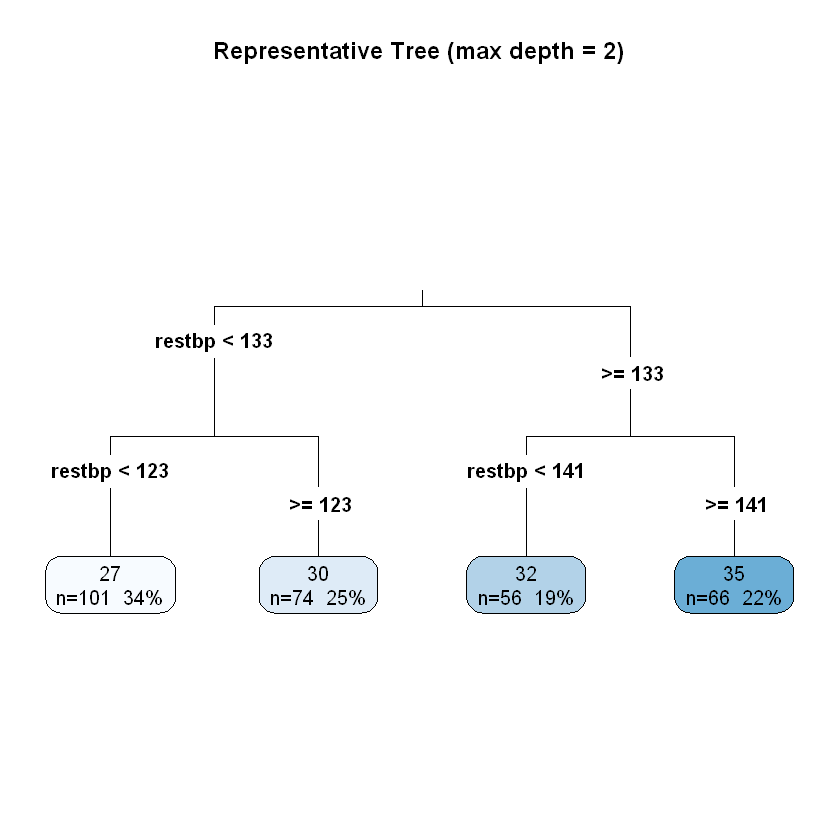

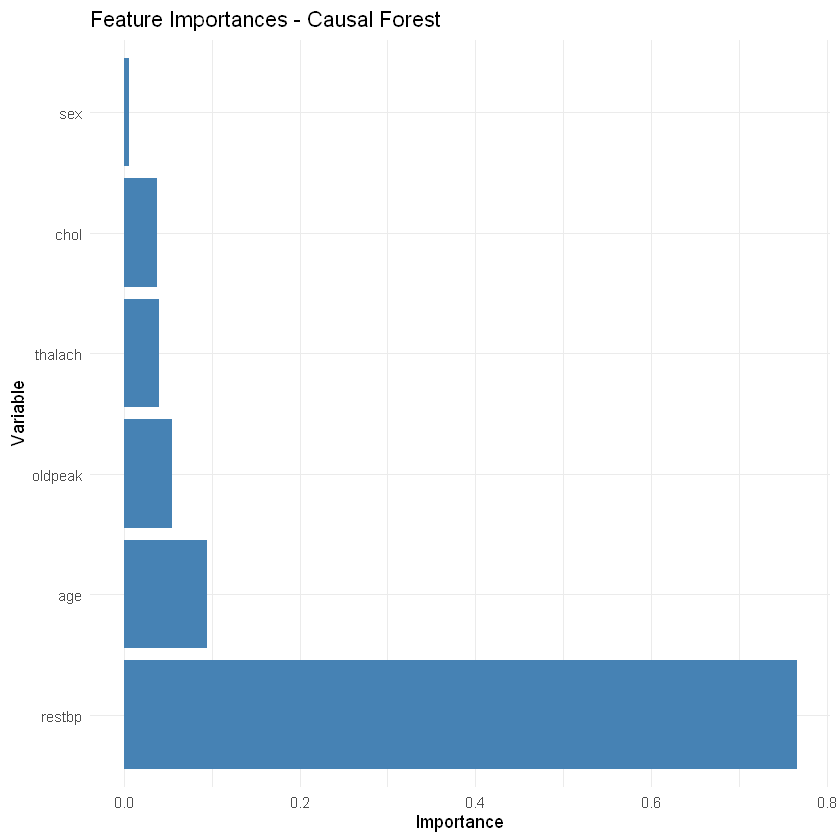

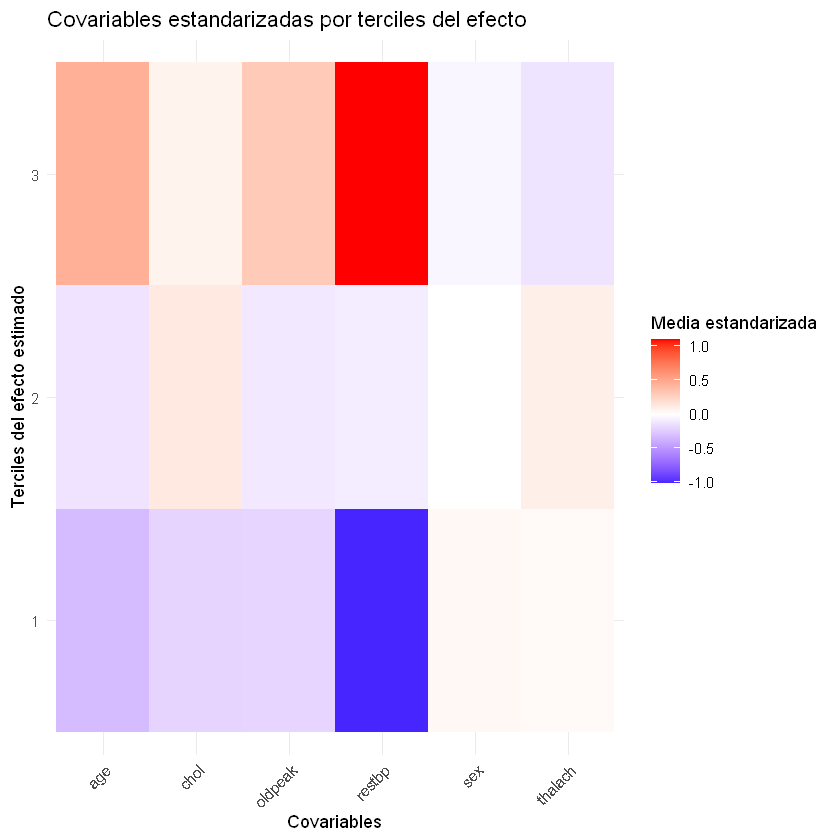

In [16]:
# --- Parte 2: Causal Forest ---
library(tidyverse)
library(grf)
library(rpart)
library(rpart.plot)
library(ggplot2)
library(forcats)
library(tidyr)
library(scales)

set.seed(123)

# Lectura y limpieza
data <- read_csv("C:/Users/VICTOR/Documents/GitHub/Decision_Trees/R/input/processed.cleveland.data", col_names = FALSE)
colnames(data) <- c('age', 'sex', 'cp', 'restbp', 'chol', 'fbs', 
                    'restecg', 'thalach', 'exang', 'oldpeak', 
                    'slope', 'ca', 'thal', 'hd')

data <- data %>%
  mutate(across(where(is.character), ~ na_if(., "?"))) %>%
  drop_na() %>%
  mutate(across(everything(), as.numeric)) %>%
  mutate(y = ifelse(hd > 0, 1, 0))

# Categóricas sin hd
variables_categoricas <- c("cp", "restecg", "slope", "ca", "thal")
data <- data %>%
  mutate(across(all_of(variables_categoricas), as.factor))

# --- Tratamiento y outcome simulados ---
n <- nrow(data)
set.seed(123)
data <- data %>%
  mutate(
    T = rbinom(n, 1, 0.5),
    eps = rnorm(n),
    Y = (1 + 0.05 * age + 0.3 * sex + 0.2 * restbp) * T + 0.5 * oldpeak * eps
  ) %>%
  select(-eps)

# --- Efecto promedio (OLS) ---
ols_fit <- lm(Y ~ T, data = data)
summary(ols_fit)

# --- Causal Forest ---
X <- data %>%
  select(age, sex, restbp, chol, thalach, oldpeak) %>%
  as.matrix()
Y <- data$Y
W <- data$T

set.seed(123)
cf <- causal_forest(X, Y, W, num.trees = 2000)

# Predicciones
tau_hat <- predict(cf)$predictions

# --- Árbol representativo (max_depth = 2) ---
tree_rep <- rpart(tau_hat ~ age + sex + restbp + chol + thalach + oldpeak,
                  data = data.frame(X, tau_hat),
                  control = rpart.control(maxdepth = 2))
rpart.plot(tree_rep, type = 3, extra = 101,
           main = "Representative Tree (max depth = 2)")

# --- Importancia de variables ---
varimp <- variable_importance(cf)
ranked <- order(varimp, decreasing = TRUE)
importances <- data.frame(
  variable = colnames(X)[ranked],
  importance = varimp[ranked]
)

ggplot(importances, aes(fct_rev(fct_reorder(variable, importance)), importance)) +
  geom_col(fill = "steelblue") +
  coord_flip() +
  labs(
    x = "Variable",
    y = "Importance",
    title = "Feature Importances - Causal Forest"
  ) +
  theme_minimal()

# --- Covariables estandarizadas por terciles del efecto ---
X_std <- scale(X) %>% as.data.frame()
data$tau_tercile <- ntile(tau_hat, 3)

means_by_tercile <- X_std %>%
  mutate(tercile = data$tau_tercile) %>%
  group_by(tercile) %>%
  summarize(across(everything(), mean), .groups = "drop")

heatmap_data <- means_by_tercile %>%
  pivot_longer(-tercile, names_to = "variable", values_to = "mean")

ggplot(heatmap_data, aes(x = variable, y = factor(tercile), fill = mean)) +
  geom_tile() +
  scale_fill_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0) +
  labs(
    x = "Covariables",
    y = "Terciles del efecto estimado",
    fill = "Media estandarizada",
    title = "Covariables estandarizadas por terciles del efecto"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
